# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## 1. Business Understanding
In this analysis we will going to outline the findings to the following questions:

1. which type of offers is attracting people, what is the best offer in there.
2. How people respond to the offers, and which demographics groups respond better to offers
3. Finally we will build a prediction model to predict weather customer will respond to and offer or not.

## 2. Data Understanding

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt
import progressbar

from matplotlib.ticker import PercentFormatter

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## 3. Data Preparation

In [6]:
def prep_portfolio(portfolio):
    
    #decode channel
    portfolio['email'] = portfolio.channels.apply(lambda x:1 if 'email' in x else 0)
    portfolio['mobile'] = portfolio.channels.apply(lambda x:1 if 'mobile' in x else 0)
    portfolio['web'] = portfolio.channels.apply(lambda x:1 if 'web' in x else 0)
    portfolio['social'] = portfolio.channels.apply(lambda x:1 if 'social' in x else 0)
    portfolio.drop(columns={'channels'}, inplace=True)
    
    #decode offer_type
    portfolio['bogo'] = portfolio.offer_type.apply(lambda x:1 if 'bogo' in x else 0)
    portfolio['informational'] = portfolio.offer_type.apply(lambda x:1 if 'informational' in x else 0)
    portfolio['discount'] = portfolio.offer_type.apply(lambda x:1 if 'discount' in x else 0)
    
    # convert duration from days to hours
    portfolio.duration = portfolio.duration * 24
    
    #rename column id to offer_id
    portfolio.rename(columns={'id':'offer_id'}, inplace=True)
    portfolio['offer_number'] = portfolio.index.astype(str) + '-' + portfolio['offer_type'].str[:1]
    return portfolio

In [7]:
portfolio_df = prep_portfolio(portfolio.copy())
portfolio_df

,reward,difficulty,duration,offer_type,offer_id,email,mobile,web,social,bogo,informational,discount,offer_number
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1,1,0,0,0-b
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,1-b
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,1,0,2-i
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0,3-b
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0,0,0,1,4-d
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,0,1,5-d
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,0,1,6-d
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,0,1,0,7-i
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,8-b
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,0,1,9-d


In [8]:
def prep_profile(profile):
    #convert age to int
    profile.age = profile.age.astype(int)
    
    # we will devide ages as groups,
    # 2 to 39 young adult
    # 40 to 59 Mid-Ageded Adult
    # >= 60 Old Adults
    # 118 no information
    profile['young_adults'] = profile.age.apply(lambda x:1 if (x >= 0 and  x <40)  else 0)
    profile['mid_aged'] = profile.age.apply(lambda x:1 if (x >= 40 and  x < 60) else 0)
    profile['old_adults'] = profile.age.apply(lambda x:1 if (x >= 60 and  x < 79) else 0)
    profile['no_info'] = profile.age.apply(lambda x:1 if x==118 else 0)
    
    #rename column id 
    profile.rename(columns={'id':'profile_id'}, inplace=True)
    
    #convert column to datetime
    profile.became_member_on = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
    return profile

In [9]:
profile_df = prep_profile(profile.copy())
profile_df

,gender,age,profile_id,became_member_on,income,young_adults,mid_aged,old_adults,no_info
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,0,1,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,0,1,0,0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,0,1,0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0,0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,0,0,0,0


In [10]:
def prep_transcript(transcript):
    
    #split value to offer_id and amount
    transcript['key'] = transcript['value'].apply(lambda x: list(x.keys())[0])
    transcript['_value'] = transcript['value'].apply(lambda x: list(x.values())[0])
    transcript['e_reward'] = transcript['value'].apply(lambda x: list(x.values())[1] if len(x.values())>1 else 0 )
    
    transcript = transcript.drop(columns={'value'})
    
    transcript['offer_id'] = np.where(transcript['key'] == 'offer id', transcript['_value'], np.NaN)
    transcript['offer_id'] = np.where(transcript['key'] == 'offer_id', transcript['_value'], transcript['offer_id'])
    transcript['amount'] = np.where(transcript['key'] == 'amount', transcript['_value'], np.NaN)
    transcript['key'] = np.where(transcript['key'] == 'offer id', 'offer_id', transcript['key'])
    
    transcript.drop(columns={'_value'}, inplace=True)
    
    transcript['amount'] = transcript['amount'].astype(np.float64)
    transcript['e_reward'] = transcript['e_reward'].astype(np.int32)
    
    transcript['received'] = transcript.event.apply(lambda x: 1 if x == 'offer received' else 0)
    transcript['completed'] = transcript.event.apply(lambda x: 1 if x == 'offer completed' else 0)
    transcript['viewed'] = transcript.event.apply(lambda x: 1 if x == 'offer viewed' else 0)
    return transcript

In [11]:
transcript_df = prep_transcript(transcript.copy())
transcript_df

,person,event,time,key,e_reward,offer_id,amount,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer_id,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer_id,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer_id,0,2906b810c7d4411798c6938adc9daaa5,NaN,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer_id,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer_id,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,amount,0,NaN,1.59,0,0,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,amount,0,NaN,9.53,0,0,0
306531,a00058cf10334a308c68e7631c529907,transaction,714,amount,0,NaN,3.61,0,0,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,amount,0,NaN,3.53,0,0,0


In [12]:
def split_transcript(transcript):
    
    events_df = transcript[transcript.event!='transaction']
    events_df.drop(columns={'amount'}, inplace=True)
    
    transactions_df = transcript[transcript.event=='transaction'].copy()
    transactions_df.drop(columns={'received','completed','viewed', 'offer_id','event', 'key', 'e_reward'}, inplace=True)
    
    return events_df, transactions_df
    

In [13]:
events_df, transactions_df = split_transcript(transcript_df)

C:\Users\malek_mx2lou4\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
#check for duplicateion
events_df.duplicated().sum()

397

In [15]:
#drop duplicates
events_df = events_df.drop_duplicates()

In [16]:
transactions_df.head(), events_df.head()

(                                 person  time  amount
 12654  02c083884c7d45b39cc68e1314fec56c     0    0.83
 12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     0   34.56
 12659  54890f68699049c2a04d415abc25e717     0   13.23
 12670  b2f1cd155b864803ad8334cdf13c4bd2     0   19.51
 12671  fe97aa22dd3e48c8b143116a8403dd52     0   18.97,
                              person           event  time       key  e_reward  \
 0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0  offer_id         0   
 1  a03223e636434f42ac4c3df47e8bac43  offer received     0  offer_id         0   
 2  e2127556f4f64592b11af22de27a7932  offer received     0  offer_id         0   
 3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0  offer_id         0   
 4  68617ca6246f4fbc85e91a2a49552598  offer received     0  offer_id         0   
 
                            offer_id  received  completed  viewed  
 0  9b98b8c7a33c4b65b9aebfe6a799e6d9         1          0       0  
 1  0b1e1539f2cc45b7b9fa7c272da2e1d7   

In [17]:
def join_events(events_df, portfolio_df, profile_df):
    events_df = events_df.join(portfolio_df.set_index('offer_id'), on='offer_id', how='left', lsuffix='_trans')
    events_df = events_df.join(profile_df.set_index('profile_id'), on='person', how='left') 
    
    events_df.drop(columns={'key'}, inplace=True)
    return events_df

In [18]:
events_df_all = join_events(events_df.copy(), portfolio_df, profile_df)
print(events_df_all)

                                  person            event  time  e_reward  \
0       78afa995795e4d85b5d9ceeca43f5fef   offer received     0         0   
1       a03223e636434f42ac4c3df47e8bac43   offer received     0         0   
2       e2127556f4f64592b11af22de27a7932   offer received     0         0   
3       8ec6ce2a7e7949b1bf142def7d0e0586   offer received     0         0   
4       68617ca6246f4fbc85e91a2a49552598   offer received     0         0   
...                                  ...              ...   ...       ...   
306497  a6f84f4e976f44508c358cc9aba6d2b3  offer completed   714         3   
306506  b895c57e8cd047a8872ce02aa54759d6  offer completed   714         2   
306507  8dda575c2a1d44b9ac8e8b07b93d1f8e     offer viewed   714         0   
306509  8431c16f8e1d440880db371a68f82dd0  offer completed   714         2   
306527  24f56b5e1849462093931b164eb803b5  offer completed   714         2   

                                offer_id  received  completed  viewed  rewa

In [19]:
def join_transactions(transactions_df, profile_df):
    transactions_df = transactions_df.join(profile_df.set_index('profile_id'), on='person', how='left') 
    return transactions_df 

In [20]:
transactions_df_all = join_transactions(transactions_df.copy(), profile_df)
transactions_df_all

,person,time,amount,gender,age,became_member_on,income,young_adults,mid_aged,old_adults,no_info
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83,F,20,2016-07-11,30000.0,1,0,0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,M,42,2016-01-17,96000.0,0,1,0,0
12659,54890f68699049c2a04d415abc25e717,0,13.23,M,36,2017-12-28,56000.0,1,0,0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,F,55,2017-10-16,94000.0,0,1,0,0
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,F,39,2017-12-17,67000.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,M,66,2018-01-01,47000.0,0,0,1,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,M,52,2018-04-08,62000.0,0,1,0,0
306531,a00058cf10334a308c68e7631c529907,714,3.61,F,63,2013-09-22,52000.0,0,0,1,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,M,57,2016-07-09,40000.0,0,1,0,0


## Data Analysis

In [21]:
sns.set_style( "ticks" ,
 {"xtick.major.size":8,
"ytick.major.size":8})


# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

<AxesSubplot:xlabel='income', ylabel='gender'>

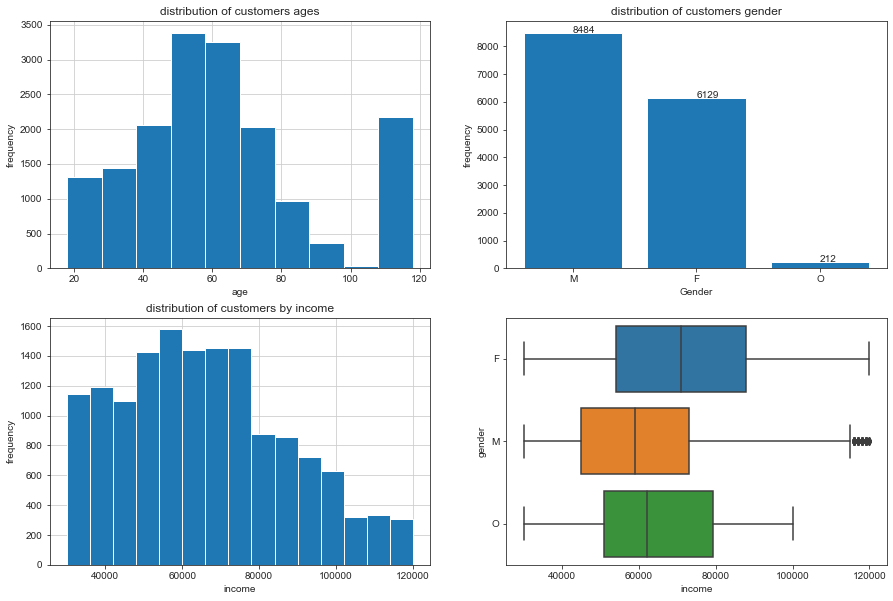

In [22]:

#fig = plt.figure()
#plt.figure(figsize=(18, 18))

fig, axes = plt.subplots(2, 2, figsize=(15,10))

# distribution of customers ages
plt.subplot(2, 2, 1)
profile_df.age.hist()
plt.xlabel('age')
plt.ylabel('frequency');
plt.title('distribution of customers ages')


plt.subplot(2, 2, 2)

#number of customer for each gender
gender_counts = profile_df.gender.value_counts()
plt.bar(gender_counts.index, gender_counts);

plt.xlabel('Gender')
plt.ylabel('frequency');
plt.title('distribution of customers gender')
addlabels(gender_counts.index,gender_counts);

plt.subplot(2, 2, 3)


profile_df.income.hist(bins=15);
plt.xlabel('income')
plt.ylabel('frequency');
plt.title('distribution of customers by income')

plt.subplot(2, 2, 4)

sns.boxplot( x=profile_df["income"],  y = profile_df['gender'] )

In [23]:
profile_df['year'] = pd.DatetimeIndex(profile_df['became_member_on']).year
profile_df['month'] = pd.DatetimeIndex(profile_df['became_member_on']).month
profile_df

,gender,age,profile_id,became_member_on,income,young_adults,mid_aged,old_adults,no_info,year,month
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,1,2017,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,1,0,0,2017,7
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,1,2018,7
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,0,1,0,2017,5
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,1,2017,8
...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,0,1,0,0,2018,6
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,0,1,0,2018,7
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0,0,2017,1
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,0,0,0,0,2016,3


Text(0.5, 1.0, 'memberships over years')

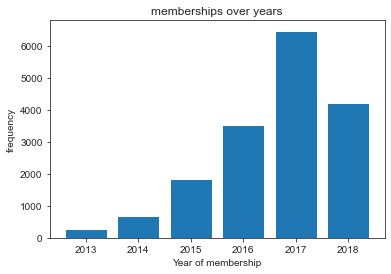

In [24]:
membership_df = profile_df['year'].value_counts()
plt.bar(membership_df.index, membership_df)

plt.xlabel('Year of membership')
plt.ylabel('frequency');
plt.title('memberships over years')


In [25]:
transactions_df_all

,person,time,amount,gender,age,became_member_on,income,young_adults,mid_aged,old_adults,no_info
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83,F,20,2016-07-11,30000.0,1,0,0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,M,42,2016-01-17,96000.0,0,1,0,0
12659,54890f68699049c2a04d415abc25e717,0,13.23,M,36,2017-12-28,56000.0,1,0,0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,F,55,2017-10-16,94000.0,0,1,0,0
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,F,39,2017-12-17,67000.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,M,66,2018-01-01,47000.0,0,0,1,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,M,52,2018-04-08,62000.0,0,1,0,0
306531,a00058cf10334a308c68e7631c529907,714,3.61,F,63,2013-09-22,52000.0,0,0,1,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,M,57,2016-07-09,40000.0,0,1,0,0


<Figure size 432x288 with 0 Axes>

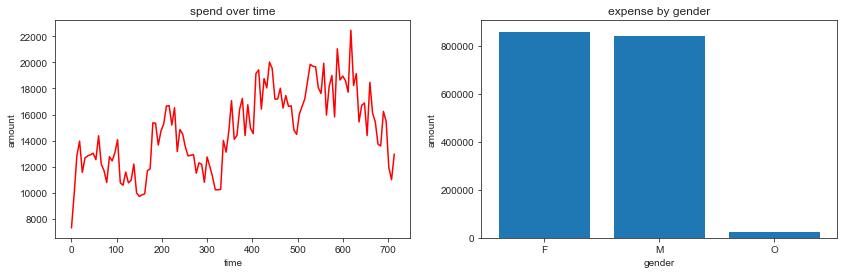

In [26]:
fig = plt.figure()
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
time_amount_df = transactions_df_all[['time','amount']].groupby('time').sum()
plt.plot(time_amount_df.index,time_amount_df, color='red')
plt.xlabel('time')
plt.ylabel('amount');
plt.title('spend over time');


plt.subplot(1, 2, 2)
amount_gender = transactions_df_all[['gender','amount']].groupby('gender').sum()
plt.bar(amount_gender.index, amount_gender.amount)
plt.xlabel('gender')
plt.ylabel('amount');
plt.title('expense by gender');


In [27]:
# to check which offer is completed, we apply method to consider only offer completed with the duration

In [28]:
#before apply refinement
print ( "offer recieved:" , events_df_all.received.sum() , "| offer viewed:" , events_df_all.viewed.sum() 
       , "| offer completed:" , events_df_all.completed.sum() )

offer recieved: 76277 | offer viewed: 57725 | offer completed: 33182


In [29]:
len(events_df_all.person.unique())

16994

In [30]:
len(events_df_all[events_df_all.received==1].person.unique())

16994

In [31]:
def refine_offer_status(events_df_all, transactions_df_all):
    '''
    Description:
    Create Data Model that will define if received offers has converted to transactions or not.

    Parameters:
    events_df_all: events dataframe that contains offer process (offer recieved, offer viewed, offer completed)
    transactions_df_all: transaction dataframe
    '''
    df_result = [] 
    
    #get all users who received offer
    users_list = events_df_all['person'].unique() 
    cnter = 0
    bar = progressbar.ProgressBar(maxval=len(users_list)+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for usr_id in users_list:

        #user = profile_new[profile_new['profile_id']==usr_id]
        user_events = events_df_all[events_df_all['person']==usr_id]
        transaction_data = transactions_df_all[transactions_df_all['person']==usr_id]
        
        received_data = user_events[user_events['received'] == 1]
        viewed_data = user_events[user_events['viewed'] == 1]
        completed_data = user_events[user_events['completed'] == 1]
        # Update the progress bar
        cnter+=1 
        bar.update(cnter)
        
        for idx, recived_offer in received_data.iterrows():
            
            converted = 0
            #completed_without_view = 0
            
            offer_id = recived_offer.offer_id
            offer_type = recived_offer['offer_type']
            duration = recived_offer['duration']
            difficulty = recived_offer['difficulty']
            start = recived_offer.time
            end = start + duration
            
            recieve_time = recived_offer.time
            cust_response = 0
            
            viewed_offer = viewed_data[(viewed_data.offer_id==offer_id) & 
                                   (viewed_data.time >= start) & (viewed_data.time <= end)]
            viewed_time = viewed_offer.time.values[0] if len(viewed_offer) > 0 else -1
            viewed = 1 if len(viewed_offer) >0 else 0
            
            completed_offer = completed_data[(completed_data.offer_id==offer_id) & 
                              (completed_data.time >= start) & (completed_data.time <= end)]
            completion_time = completed_offer.time.values[0] if len(completed_offer) > 0 else -1
            completed = 1 if len(completed_offer) > 0 else 0
            
            transitions_in_offers = np.logical_and(transaction_data['time'] >= start, 
                                                   transaction_data['time'] <= end)

            transitions_in_offers = transaction_data[transitions_in_offers]

            total = transitions_in_offers['amount'].sum()
            
            if offer_type in ['bogo','discount'] :
                
                if (total >= difficulty and viewed_time>=0 and completion_time>=0):
                    converted = 1
                    
            elif offer_type in ['informational']:
                if (total > 0 and viewed_time>=0):
                    converted = 1
                
            row_data = {'offer_id': offer_id, 'offer_type': offer_type, 'person': usr_id, 
                        'converted': int(converted), 
                        'viewed': viewed, 'completed': completed, 'amount':total}
            
            row_data.update(recived_offer[['reward','difficulty','duration','offer_type','email','mobile',
                                           'web','social','bogo','informational','discount','offer_number', 'gender','age',
                                           'became_member_on','income','young_adults','mid_aged','old_adults',
                                           'no_info']].squeeze().to_dict())
                 
            df_result.append(row_data)
        
            
    bar.finish()
    return pd.DataFrame(df_result)

In [32]:
events_refined_df = refine_offer_status(events_df_all.copy(), transactions_df_all.copy())

[========================================================================] 100%


In [33]:
#number of received offers ,  total conversion rate
events_refined_df.count()['offer_id'] , events_refined_df.converted.mean()

(76277, 0.45353120862120955)

### Q1- which type of offers is attracting people, what is the best offer in there.


In [34]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

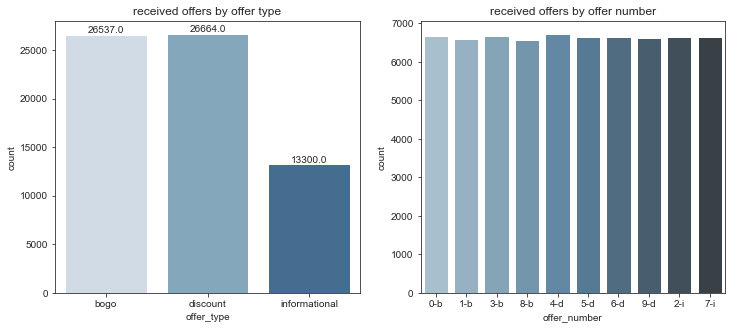

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

#number of offers type received
recieved_df = events_refined_df[['offer_type','gender']].groupby(['offer_type','gender']).size()
recieved_df = recieved_df.reset_index(name='count')
p1 = sns.barplot(x = 'offer_type', y = 'count',  data = recieved_df,ci=None,
            estimator=sum,color="salmon", saturation=.5,palette='Blues', ax=axes[0])


#number of offers type received
recieved_df = events_refined_df[['offer_type', 'offer_number','gender']].groupby(['offer_type', 'offer_number','gender']).size()
recieved_df = recieved_df.reset_index(name='count')
p2 = sns.barplot(x = 'offer_number', y = 'count',  data = recieved_df,ci=None,
            estimator=sum,color="salmon", saturation=.5, palette='Blues_d', ax=axes[1])

axes[0].set_title('received offers by offer type')
axes[1].set_title('received offers by offer number');

show_values(p1)


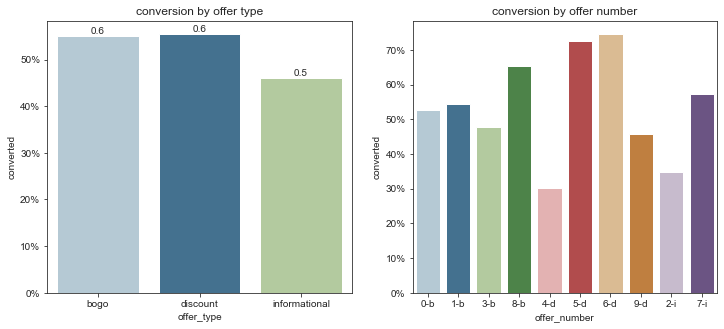

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

#number of offers type received

converted = events_refined_df[['offer_type','gender','converted']].groupby(['offer_type','gender']).mean() 
converted = converted.reset_index()
#converted.converted = converted.converted * 100
p1 = sns.barplot(x = 'offer_type', y = 'converted',  data = converted,ci=None,
            estimator=np.mean, saturation=.5,palette='Paired', ax=axes[0])


#number of offers type received
converted =  events_refined_df[['offer_type','gender','offer_number','converted']].groupby(['offer_type','gender','offer_number',]).mean()
converted = converted.reset_index() 
#converted.converted = converted.converted * 100
sns.barplot(x = 'offer_number', y = 'converted',  data = converted,ci=None,
            estimator=np.mean, saturation=.5, palette='Paired', ax=axes[1]);


from matplotlib.ticker import PercentFormatter

axes[0].yaxis.set_major_formatter(PercentFormatter(1))
axes[1].yaxis.set_major_formatter(PercentFormatter(1))

axes[0].set_title('conversion by offer type');
axes[1].set_title('conversion by offer number');
show_values(p1)


In [37]:
viewd_offers = events_refined_df[events_refined_df.viewed==1]
converted_offers = events_refined_df[events_refined_df.converted==1]
data = {'channel':['email', 'mobile','web', 'social'],
        'received':[events_refined_df.email.sum(), events_refined_df.mobile.sum(), \
    events_refined_df.web.sum(), events_refined_df.social.sum() ], 'viewed':[viewd_offers.email.sum(), viewd_offers.mobile.sum(), \
    viewd_offers.web.sum(), viewd_offers.social.sum() ], 'converted':[converted_offers.email.sum(), converted_offers.mobile.sum(), \
    converted_offers.web.sum(), converted_offers.social.sum() ]}
df = pd.DataFrame(data, columns = ['channel', 'received', 'viewed', 'converted'])
df['percent_views'] = df.viewed / df.received
df['percent_converted'] = df.converted / df.received
df = df.sort_values(by=['percent_views'],ascending=False) 


In [38]:
df

,channel,received,viewed,converted,percent_views,percent_converted
3,social,45683,42054,24952,0.920561,0.546199
1,mobile,68609,54163,32975,0.789445,0.480622
0,email,76277,56895,34594,0.745900,0.453531
2,web,61001,44025,27210,0.721709,0.446058


Text(0.5, 1.0, 'Conversion by Channels')

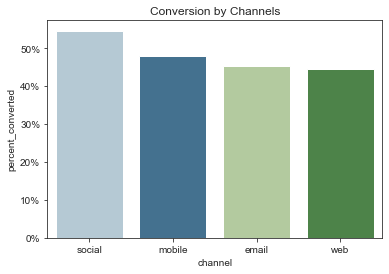

In [39]:
#conversion by channels
sns.barplot(x = 'channel', y = 'percent_converted',  data = df,ci=None,
             saturation=.5,palette='Paired');
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_title('Conversion by Channels')


### Q2 - How people respond to the offers, and which demographics groups respond better to offers


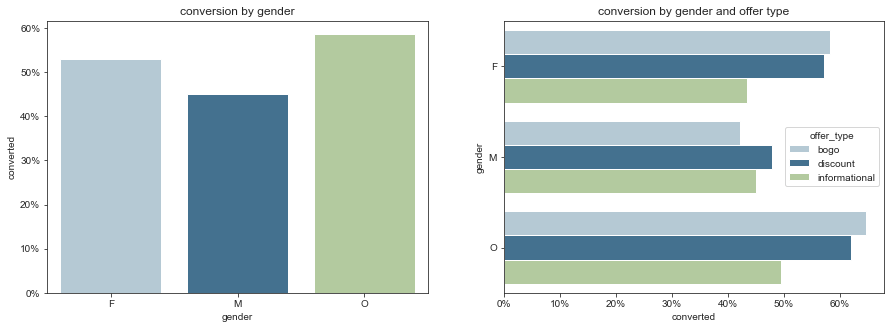

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

#number of offers type received

converted = events_refined_df[['offer_type','gender','converted']].groupby(['offer_type','gender']).mean() 
converted = converted.reset_index()
#converted.converted = converted.converted * 100
sns.barplot(x = 'gender', y = 'converted',  data = converted,ci=None,
            estimator=np.mean, saturation=.5, ax=axes[0],palette='Paired')


#number of offers type received
converted =  events_refined_df[['offer_type','gender','offer_number','converted']].groupby(['offer_type','gender','offer_number',]).mean()
converted = converted.reset_index() 
#converted.converted = converted.converted * 100
sns.barplot(y = 'gender', x = 'converted',  data = converted,ci=None,
            estimator=np.mean, hue='offer_type', saturation=.5,  ax=axes[1],palette='Paired');


from matplotlib.ticker import PercentFormatter

axes[0].yaxis.set_major_formatter(PercentFormatter(1))
axes[1].xaxis.set_major_formatter(PercentFormatter(1))

axes[0].set_title('conversion by gender');
axes[1].set_title('conversion by gender and offer type');

In [41]:
def get_agegroup(age):
    age_group = 'no_info'
    if (age >= 0 and age <40):
        age_group = 'young adults'
    elif (age>= 40 and  age < 60):
        age_group = 'mid aged'
    elif (age >= 60 and  age < 80):
        age_group = 'old adults'
    else:
        age_group = 'no_info'
    return age_group

events_refined_df['age_group'] = events_refined_df['age'].apply(get_agegroup)

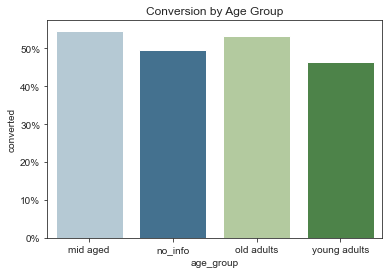

In [42]:
ax = plt.gca()

#number of offers type received

converted = events_refined_df[['offer_type','gender','converted','age_group']].groupby(['offer_type','gender','age_group']).mean() 
converted = converted.reset_index()
#converted.converted = converted.converted * 100
sns.barplot(x = 'age_group', y = 'converted',  data = converted,ci=None,
            estimator=np.mean, saturation=.5, ax=ax,palette='Paired')



ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_title('Conversion by Age Group');



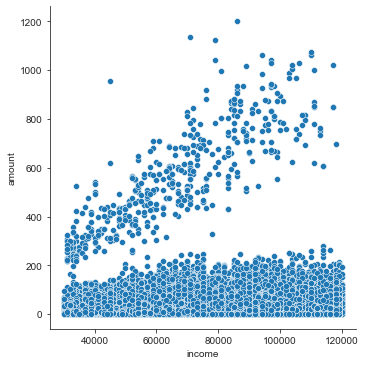

In [43]:
sns.relplot(x="income", y="amount", data=events_refined_df);

In [44]:
events_refined_df

,offer_id,offer_type,person,converted,viewed,completed,amount,reward,difficulty,duration,...,offer_number,gender,age,became_member_on,income,young_adults,mid_aged,old_adults,no_info,age_group
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,78afa995795e4d85b5d9ceeca43f5fef,1,1,1,37.67,5,5,168,...,3-b,F,75,2017-05-09,100000.0,0,0,1,0,old adults
1,5a8bc65990b245e5a138643cd4eb9837,informational,78afa995795e4d85b5d9ceeca43f5fef,1,1,0,49.39,0,0,72,...,7-i,F,75,2017-05-09,100000.0,0,0,1,0,old adults
2,ae264e3637204a6fb9bb56bc8210ddfd,bogo,78afa995795e4d85b5d9ceeca43f5fef,1,1,1,48.28,10,10,168,...,0-b,F,75,2017-05-09,100000.0,0,0,1,0,old adults
3,f19421c1d4aa40978ebb69ca19b0e20d,bogo,78afa995795e4d85b5d9ceeca43f5fef,1,1,1,48.28,5,5,120,...,8-b,F,75,2017-05-09,100000.0,0,0,1,0,old adults
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,a03223e636434f42ac4c3df47e8bac43,0,1,0,1.09,5,20,240,...,4-d,None,118,2017-08-04,NaN,0,0,0,1,no_info
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,5a8bc65990b245e5a138643cd4eb9837,informational,01fe5ec668f241608eb2f7ec374cb1b7,1,1,0,19.92,0,0,72,...,7-i,M,44,2017-08-02,64000.0,0,1,0,0,mid aged
76273,fafdcd668e3743c1bb461111dcafc2a4,discount,6e1d4ac6dc3d4a9788b1b82ea4ae6ebf,0,1,0,5.11,2,10,240,...,6-d,None,118,2015-10-06,NaN,0,0,0,1,no_info
76274,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,d825b707198046e39baa4fdcfa11d621,0,0,1,28.42,5,5,168,...,3-b,M,61,2018-04-23,73000.0,0,0,1,0,old adults
76275,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,c207a8a8ef5c47ee970ca45f859e07eb,1,1,1,75.84,3,7,168,...,5-d,F,52,2017-12-23,86000.0,0,1,0,0,mid aged


# 4.Data Modeling

In [45]:
events_refined_df.iloc[0]

offer_id            9b98b8c7a33c4b65b9aebfe6a799e6d9
offer_type                                      bogo
person              78afa995795e4d85b5d9ceeca43f5fef
converted                                          1
viewed                                             1
completed                                          1
amount                                         37.67
reward                                             5
difficulty                                         5
duration                                         168
email                                              1
mobile                                             1
web                                                1
social                                             0
bogo                                               1
informational                                      0
discount                                           0
offer_number                                     3-b
gender                                        

In [46]:
df_refined = events_refined_df

def decode(x):
    y=0
    if x=='M': y=1
    elif x=='F': y=2
    else: y=0
    return y
df_refined['gender'] = df_refined['gender'].apply(decode)
df_refined['membership_year']  = df_refined.became_member_on.dt.year

df_refined['offer_number']  = df_refined.offer_number.str[0]                                                                        

In [47]:
df_refined.offer_number

0        3
1        7
2        0
3        8
4        4
        ..
76272    7
76273    6
76274    3
76275    5
76276    5
Name: offer_number, Length: 76277, dtype: object

In [48]:
df_refined = df_refined[['offer_number','amount','converted', 'difficulty', 'duration', 'reward', 
       'bogo', 'discount', 'mobile', 'social', 'web', 'gender', 
       'income', 'age', 'membership_year']]

In [49]:
df_refined=df_refined.dropna()

In [50]:
x = df_refined.loc[:, df_refined.columns != 'converted'].values  
y = df_refined.loc[:, df_refined.columns == 'converted'].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [51]:
est_rfc = RandomForestClassifier(random_state=42) 
estimators = [10, 50, 100, 150, 200, 250, 300] 
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None) 
min_samples_split = [2, 5, 10] 
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': estimators, 'max_depth': max_depth,
               'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf}
 
model_RF = RandomizedSearchCV(estimator = est_rfc,param_distributions = grid_params, scoring=None, n_iter = 100,
                               cv = 3,verbose=2,random_state=42, n_jobs = 3)
model_RF.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   37.3s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  6.5min finished
C:\Users\malek_mx2lou4\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=3,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         250, 300]},
                   random_state=42, verbose=2)

## Evaluate the model

In [52]:
y_pred_rf = model_RF.predict(X_train)

clf_accuracy = accuracy_score(y_train, y_pred_rf)
clf_f1_score = f1_score(y_train, y_pred_rf)
    
print("accuracy: %.3f" % (clf_accuracy))
print("f1-score: %.3f" % (clf_f1_score))

accuracy: 0.933
f1-score: 0.933


In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     23668
           1       0.91      0.96      0.93     22882

    accuracy                           0.93     46550
   macro avg       0.93      0.93      0.93     46550
weighted avg       0.93      0.93      0.93     46550

